## Ciência de Dados em Larga Escala  
### Trabalho Prático - Performance Analysis  
## Bruno Costa e José Santos
# Grupo Z

---

##  Sumário  
- Apresentação breve do trabalho e das bibliotecas estudadas (PySpark, Dask, Modin, JobLib e Koalas).  
- Descrição dos materiais e métodos usados para realizar os experimentos.  
- Comparação entre as bibliotecas Dask e Koalas (PySpark).  
- Ajuste do estudo para trabalhar com datasets contendo 2 e 3 arquivos no formato Parquet.  

---

## Introdução  
No universo de big data e machine learning, a escolha correta das bibliotecas é fundamental para garantir eficiência e boa performance nas pipelines de processamento. O objetivo deste trabalho é explorar e comparar várias bibliotecas Python amplamente usadas para manipular grandes volumes de dados e executar tarefas de machine learning.

**PySpark** é uma interface Python para o Apache Spark, um framework para computação distribuída que permite processamento paralelo em clusters, facilitando operações como leitura, agregação e transformação de grandes conjuntos de dados. Suas vantagens principais são a escalabilidade e eficiência em ambientes distribuídos, sendo amplamente empregado para processamento em larga escala, ETL e análises em tempo real.

**Dask** é uma biblioteca Python que habilita paralelismo e processamento distribuído, estendendo as funcionalidades do pandas para trabalhar com dados que não cabem na memória. Ela permite operações paralelas e distribuídas e é valorizada pela interface familiar aos usuários do pandas, além de sua escalabilidade e integração com outras ferramentas de big data. Dask é bastante utilizado para processamento, análise e machine learning em grandes conjuntos de dados.

**Koalas** fornece uma API semelhante à do pandas, porém para Apache Spark, facilitando a migração de código pandas para ambientes distribuídos com poucas alterações. Suas vantagens incluem a facilidade na transição para Spark e a capacidade de usar operações pandas em escala distribuída, sendo útil para manipulação de dados em larga escala com a familiaridade do pandas, porém no Spark.

O foco deste trabalho é identificar os gargalos de performance das diferentes bibliotecas, analisar as diferenças em suas sintaxes e definir quais operações são mais adequadas para cada uma delas, além de familiarizar-se com as funcionalidades suportadas por pandas, scikit-learn e numpy. Para isso, foi repetido o estudo comparativo entre Koalas (PySpark) e Dask, utilizando o dataset NYC Taxi Driver, avaliando o tempo de execução de diversas operações. Posteriormente, o estudo foi ampliado para incluir Modin, JobLib e RapidsAI, usando o mesmo dataset, com expansão para dois e três arquivos Parquet.


---

## Materiais e Métodos  
Para executar o projeto, foram usados recursos da Google Cloud Platform (GCP). Foi criada uma máquina virtual (VM) e um cluster de VMs para a realização das análises. A configuração do cluster assemelha-se a uma instância i3.4xlarge da AWS, e a VM foi configurada similarmente a uma i3.16xlarge. Esses recursos foram alocados conforme os créditos disponíveis.

A VM usada é uma instância n1-standart-8 com 8 vCPUs baseadas na arquitetura AMD Milan, 32 GB de RAM e disco persistente balanceado de 500 GB, rodando Ubuntu 20.04 LTS.

Foi utilizado o conjunto de dados “TLC Trip Record Data” da Comissão de Táxi e Limusine de Nova York (TLC), que registra viagens de táxis amarelos, verdes e veículos para contratação ("For-Hire Vehicle" - FHV). Os dados contêm informações como fornecedor, data e hora da viagem, número de passageiros, distância, coordenadas de início e fim, código de tarifa, tipo de pagamento, valores de tarifa, taxas e gorjetas.

Durante o download, foram obtidos arquivos mensais de 2009 a 2011 no formato Parquet.

---

## Download do Dataset  
Foram baixados arquivos em formato Parquet referentes a viagens de táxi entre janeiro de 2009 e dezembro de 2010, seguindo os passos abaixo:

- Construção de URLs e mapeamento dos locais de armazenamento dos arquivos;  
- Criação do diretório local para armazenar os arquivos, garantindo que exista;  
- Download de todos os arquivos listados, salvando-os no diretório designado.



In [1]:
import os
import requests
url_loc = {} 
for year in range(2009, 2011):
    for m in range(1, 13):
        month = "{:02d}".format(m)
        fname = 'yellow_tripdata_%s-%s.parquet' % (year, month)
        url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/%s' % fname
        loc = 'Ficheiros/taxi_csv/%s' % fname
        url_loc[url] = loc
download_dir = 'Ficheiros/taxi_csv'
os.makedirs(download_dir, exist_ok=True)
for url, loc in url_loc.items():
    file_path = os.path.join(download_dir, os.path.basename(loc))
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {file_path}")

Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-02.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-03.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-04.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-05.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-06.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-07.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-08.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-09.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-10.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-11.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2010-01.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2010-02.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2010-03.parquet
Downloaded Ficheiros/taxi_csv/yellow_tripdata_2010-04.parquet
Download

* Sessao Spark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("project") \
    .getOrCreate()
spark.conf.set("spark.databricks.io.cache.enabled", "false")
print("spark.databricks.io.cache.enabled is %s" % spark.conf.get("spark.databricks.io.cache.enabled"))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/03 19:50:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


spark.databricks.io.cache.enabled is false


In [2]:
import pandas as pd
import pyspark
import pyarrow
import numpy as np


In [3]:
import time
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

In [4]:
import pyspark.pandas as ks

/opt/conda/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Definição das Funções de Benchmark: mede a duração da execução de uma função e armazena os resultados

In [10]:
def benchmark(f, df, benchmarks, name, **kwargs):
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    return benchmarks['duration'][-1]
 
def get_results(benchmarks):
    return pd.DataFrame.from_dict(benchmarks)

## Dask 

Inicialização e Carregamento de Dados

In [7]:
import os
import dask.dataframe as dd
from dask.distributed import Client
import time
client = Client()
parquet_file = 'data/taxi_csv/yellow_tripdata_2009-12.parquet'
dask_data = dd.read_parquet(parquet_file)
dask_benchmarks = {
    'duration': [],
    'task': [],
}
dask_benchmarks_filtered = {
    'duration': [],
    'task': [],
}
dask_benchmarks_cache = {
    'duration': [],
    'task': [],
}

2025-06-03 19:52:48,490 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 418e6ab41030746849b00bc276f5e21b initialized by task ('shuffle-transfer-418e6ab41030746849b00bc276f5e21b', 0) executed on worker tcp://127.0.0.1:41947
2025-06-03 19:52:49,463 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 418e6ab41030746849b00bc276f5e21b deactivated due to stimulus 'task-finished-1748980369.4623702'
2025-06-03 19:56:57,118 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle fc3f38b728919c348eb2f3950477270d initialized by task ('shuffle-transfer-fc3f38b728919c348eb2f3950477270d', 0) executed on worker tcp://127.0.0.1:41947
2025-06-03 19:56:57,901 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle fc3f38b728919c348eb2f3950477270d deactivated due to stimulus 'task-finished-1748980617.89984'
2025-06-03 19:58:21,158 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b0bedef458f4ff227d2b44eea9785544 initialized by task ('shuffle-transfer-b0bedef458f4ff22

# Lista de Colunas

In [8]:
dask_data = dask_data.rename(columns=str.lower)
columns_list = dask_data.columns
print(columns_list)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


# Definição das Funções de Operações

In [9]:
def read_file_parquet(df=None):
    return dd.read_parquet('Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet')
  
def count(df=None):
    return len(df)
 
def count_index_length(df=None):
    return len(df.index)
 
def mean(df):
    return df.fare_amt.mean().compute()
 
def standard_deviation(df):
    return df.fare_amt.std().compute()
 
def mean_of_sum(df):
    return (df.fare_amt + df.tip_amt).mean().compute()
 
def sum_columns(df):
    return (df.fare_amt + df.tip_amt).compute()
 
def mean_of_product(df):
    return (df.fare_amt * df.tip_amt).mean().compute()
 
def product_columns(df):
    return (df.fare_amt * df.tip_amt).compute()
  
def value_counts(df):
    return df.fare_amt.value_counts().compute()
  
def mean_of_complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.mean().compute()
  
def complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.compute()
  
def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg(
      {
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
      }
    ).compute()
  
other = groupby_statistics(dask_data)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])
 
def join_count(df, other):
    return len(dd.merge(df, other, left_index=True, right_index=True))
 
def join_data(df, other):
    return dd.merge(df, other, left_index=True, right_index=True).compute()

2025-06-03 19:50:51,330 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.73 GiB -- Worker memory limit: 7.83 GiB


# Execução dos Benchmarks

In [10]:
benchmark(read_file_parquet, df=None, benchmarks=dask_benchmarks, name='read file')
benchmark(count, df=dask_data, benchmarks=dask_benchmarks, name='count')
benchmark(count_index_length, df=dask_data, benchmarks=dask_benchmarks, name='count index length')
benchmark(mean, df=dask_data, benchmarks=dask_benchmarks, name='mean')
benchmark(standard_deviation, df=dask_data, benchmarks=dask_benchmarks, name='standard deviation')
benchmark(mean_of_sum, df=dask_data, benchmarks=dask_benchmarks, name='mean of columns addition')
benchmark(sum_columns, df=dask_data, benchmarks=dask_benchmarks, name='addition of columns')
benchmark(mean_of_product, df=dask_data, benchmarks=dask_benchmarks, name='mean of columns multiplication')
benchmark(product_columns, df=dask_data, benchmarks=dask_benchmarks, name='multiplication of columns')
benchmark(value_counts, df=dask_data, benchmarks=dask_benchmarks, name='value counts')
benchmark(mean_of_complicated_arithmetic_operation, df=dask_data, benchmarks=dask_benchmarks, name='mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, df=dask_data, benchmarks=dask_benchmarks, name='complex arithmetic ops')
benchmark(groupby_statistics, df=dask_data, benchmarks=dask_benchmarks, name='groupby statistics')
benchmark(join_count, dask_data, benchmarks=dask_benchmarks, name='join count', other=other)
benchmark(join_data, dask_data, benchmarks=dask_benchmarks, name='join', other=other)

read file took: 0.008968353271484375 seconds
count took: 0.012008190155029297 seconds
count index length took: 0.014465570449829102 seconds
mean took: 15.407151222229004 seconds
standard deviation took: 15.653548002243042 seconds
mean of columns addition took: 15.38667631149292 seconds
addition of columns took: 15.686276912689209 seconds
mean of columns multiplication took: 15.549761772155762 seconds
multiplication of columns took: 15.837326049804688 seconds
value counts took: 16.776376485824585 seconds
mean of complex arithmetic ops took: 16.63805365562439 seconds
complex arithmetic ops took: 15.190645456314087 seconds
groupby statistics took: 14.650766372680664 seconds


2025-06-03 19:53:44,277 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.54 GiB -- Worker memory limit: 7.83 GiB


join count took: 15.411818027496338 seconds
join took: 15.144436120986938 seconds


15.144436120986938

# Guardar Resultados

In [11]:
dask_res_temp = get_results(dask_benchmarks).drop_duplicates(subset='task').set_index('task')
print(dask_res_temp)
filename = 'Resultados/dask_standard1'
dask_res_temp.to_parquet(filename)

print(f'Guardado em {filename}.')

                                 duration
task                                     
read file                        0.008968
count                            0.012008
count index length               0.014466
mean                            15.407151
standard deviation              15.653548
mean of columns addition        15.386676
addition of columns             15.686277
mean of columns multiplication  15.549762
multiplication of columns       15.837326
value counts                    16.776376
mean of complex arithmetic ops  16.638054
complex arithmetic ops          15.190645
groupby statistics              14.650766
join count                      15.411818
join                            15.144436
Guardado em Resultados/dask_standard1.


# Operações com filtro

In [12]:
expr_filter = (dask_data.tip_amt >= 1) & (dask_data.tip_amt <= 5)
 
def filter_data(df):
    return df[expr_filter]
  
dask_filtered = filter_data(dask_data)

In [13]:
benchmark(read_file_parquet, df=None, benchmarks=dask_benchmarks_filtered, name='read file')
benchmark(count, dask_filtered, benchmarks=dask_benchmarks_filtered, name='count')
benchmark(count_index_length, dask_filtered, benchmarks=dask_benchmarks_filtered, name='count index length')
benchmark(mean, dask_filtered, benchmarks=dask_benchmarks_filtered, name='mean')
benchmark(standard_deviation, dask_filtered, benchmarks=dask_benchmarks_filtered, name='standard deviation')
benchmark(mean_of_sum, dask_filtered, benchmarks=dask_benchmarks_filtered, name ='mean of columns addition')
benchmark(sum_columns, df=dask_filtered, benchmarks=dask_benchmarks_filtered, name='addition of columns')
benchmark(mean_of_product, dask_filtered, benchmarks=dask_benchmarks_filtered, name ='mean of columns multiplication')
benchmark(product_columns, df=dask_filtered, benchmarks=dask_benchmarks_filtered, name='multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, dask_filtered, benchmarks=dask_benchmarks_filtered, name='mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, dask_filtered, benchmarks=dask_benchmarks_filtered, name='complex arithmetic ops')
benchmark(value_counts, dask_filtered, benchmarks=dask_benchmarks_filtered, name ='value counts')
benchmark(groupby_statistics, dask_filtered, benchmarks=dask_benchmarks_filtered, name='groupby statistics')
 
other = groupby_statistics(dask_filtered)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])
 
benchmark(join_count, dask_filtered, benchmarks=dask_benchmarks_filtered, name='join count', other=other)
benchmark(join_data, dask_filtered, benchmarks=dask_benchmarks_filtered, name='join', other=other)

read file took: 0.007888555526733398 seconds
count took: 15.091957330703735 seconds
count index length took: 15.131043195724487 seconds
mean took: 15.25171160697937 seconds
standard deviation took: 13.730218887329102 seconds
mean of columns addition took: 15.55794644355774 seconds
addition of columns took: 15.955136775970459 seconds
mean of columns multiplication took: 15.678725004196167 seconds


2025-06-03 19:56:01,330 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.65 GiB -- Worker memory limit: 7.83 GiB


multiplication of columns took: 15.84637451171875 seconds
mean of complex arithmetic ops took: 15.89311933517456 seconds
complex arithmetic ops took: 16.45020627975464 seconds
value counts took: 16.651476860046387 seconds
groupby statistics took: 16.22596764564514 seconds
join count took: 15.984034538269043 seconds
join took: 16.36372947692871 seconds


16.36372947692871

In [14]:
dask_res_filtered = get_results(dask_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')
print(dask_res_filtered)
filename_filter = 'Resultados/dask_filtered1'
dask_res_filtered.to_parquet(filename_filter)
print(f'Guardado em {filename_filter}.')

                                 duration
task                                     
read file                        0.007889
count                           15.091957
count index length              15.131043
mean                            15.251712
standard deviation              13.730219
mean of columns addition        15.557946
addition of columns             15.955137
mean of columns multiplication  15.678725
multiplication of columns       15.846375
mean of complex arithmetic ops  15.893119
complex arithmetic ops          16.450206
value counts                    16.651477
groupby statistics              16.225968
join count                      15.984035
join                            16.363729
Guardado em Resultados/dask_filtered1.


# Operações com filtro e caching

In [15]:
dask_filtered = client.persist(dask_filtered)
from distributed import wait
print('Waiting until all futures are finished')
wait(dask_filtered)
print('All futures are finished')

Waiting until all futures are finished
All futures are finished


In [16]:
benchmark(read_file_parquet, df=None, benchmarks=dask_benchmarks_cache, name='read file')
benchmark(count, dask_filtered, benchmarks=dask_benchmarks_cache, name='count')
benchmark(count_index_length, dask_filtered, benchmarks=dask_benchmarks_cache, name='count index length')
benchmark(mean, dask_filtered, benchmarks=dask_benchmarks_cache, name='mean')
benchmark(standard_deviation, dask_filtered, benchmarks=dask_benchmarks_cache, name='standard deviation')
benchmark(mean_of_sum, dask_filtered, benchmarks=dask_benchmarks_cache, name ='mean of columns addition')
benchmark(sum_columns, df=dask_filtered, benchmarks=dask_benchmarks_cache, name='addition of columns')
benchmark(mean_of_product, dask_filtered, benchmarks=dask_benchmarks_cache, name ='mean of columns multiplication')
benchmark(product_columns, df=dask_filtered, benchmarks=dask_benchmarks_cache, name='multiplication of columns')
benchmark(mean_of_complicated_arithmetic_operation, dask_filtered, benchmarks=dask_benchmarks_cache, name='mean of complex arithmetic ops')
benchmark(complicated_arithmetic_operation, dask_filtered, benchmarks=dask_benchmarks_cache, name='complex arithmetic ops')
benchmark(value_counts, dask_filtered, benchmarks=dask_benchmarks_cache, name ='value counts')
benchmark(groupby_statistics, dask_filtered, benchmarks=dask_benchmarks_cache, name='groupby statistics')
 
other = groupby_statistics(dask_filtered)
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])
 
benchmark(join_count, dask_filtered, benchmarks=dask_benchmarks_cache, name='join count', other=other)
benchmark(join_data, dask_filtered, benchmarks=dask_benchmarks_cache, name='join', other=other)

read file took: 0.009152412414550781 seconds
count took: 0.03545427322387695 seconds
count index length took: 0.031214475631713867 seconds
mean took: 0.056137800216674805 seconds
standard deviation took: 0.11504435539245605 seconds
mean of columns addition took: 0.07110762596130371 seconds
addition of columns took: 0.2650279998779297 seconds
mean of columns multiplication took: 0.06962919235229492 seconds
multiplication of columns took: 0.2863297462463379 seconds
mean of complex arithmetic ops took: 0.38831043243408203 seconds
complex arithmetic ops took: 0.6052024364471436 seconds
value counts took: 0.11748790740966797 seconds
groupby statistics took: 0.2713613510131836 seconds
join count took: 0.07017660140991211 seconds
join took: 0.11501693725585938 seconds


0.11501693725585938

In [17]:
dask_res_cache = get_results(dask_benchmarks_cache).drop_duplicates(subset='task').set_index('task')
print(dask_res_cache)
filename_cache = 'Resultados/dask_cache1'
dask_res_cache.to_parquet(filename_cache)
print(f'Guardado em {filename_cache}.')

                                duration
task                                    
read file                       0.009152
count                           0.035454
count index length              0.031214
mean                            0.056138
standard deviation              0.115044
mean of columns addition        0.071108
addition of columns             0.265028
mean of columns multiplication  0.069629
multiplication of columns       0.286330
mean of complex arithmetic ops  0.388310
complex arithmetic ops          0.605202
value counts                    0.117488
groupby statistics              0.271361
join count                      0.070177
join                            0.115017
Guardado em Resultados/dask_cache1.


In [18]:
client.restart()

## Koalas

In [19]:
koalas_data = ks.read_parquet('Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet')

koalas_benchmarks = {
    'duration': [],
    'task': [],
}

koalas_benchmarks_filtered = {
    'duration': [],
    'task': [],
}

koalas_benchmarks_cache = {
    'duration': [],
    'task': [],
}

/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_parquet`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [20]:
import pyspark.pandas as ps
current_columns = koalas_data.columns
rename_dict = {col: col.lower() for col in current_columns}
koalas_data = koalas_data.rename(columns=rename_dict)
columns_list = koalas_data.columns
print(columns_list)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


In [21]:
import pyspark.sql.functions as F
def read_file_parquet(df=None):
    return ks.read_parquet('Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet')
  
def count(df=None):
    return len(df)
 
def count_index_length(df=None):
    return len(df.index)
 
def mean(df):
    return df.fare_amt.mean()
 
def standard_deviation(df):
    return df.fare_amt.std()
 
def mean_of_sum(df):
    return (df.fare_amt + df.tip_amt).mean()
 
def sum_columns(df):
    x = df.fare_amt + df.tip_amt
    x.to_pandas()
    return x
 
def mean_of_product(df):
    return (df.fare_amt * df.tip_amt).mean()
 
def product_columns(df):
    x = df.fare_amt * df.tip_amt
    x.to_pandas()
    return x
 
def value_counts(df):
    val_counts = df.fare_amt.value_counts()
    val_counts.to_pandas()
    return val_counts
  
def complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180) * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = np.multiply(np.arctan2(np.sqrt(temp), np.sqrt(1-temp)),2)
    ret.to_pandas()
    return ret
  
def mean_of_complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180) * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = np.multiply(np.arctan2(np.sqrt(temp), np.sqrt(1-temp)),2) 
    return ret.mean()
  
def groupby_statistics(df):
    gb = df.groupby(by='passenger_count').agg(
      {
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
      }
    )
    gb.to_pandas()
    return gb
  
other = ks.DataFrame(groupby_statistics(koalas_data).to_pandas())
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])
 
def join_count(df, other):
    return len(df.merge(other.spark.hint("broadcast"), left_index=True, right_index=True))
 
def join_data(df, other):
    ret = df.merge(other.spark.hint("broadcast"), left_index=True, right_index=True)
    ret.to_pandas()
    return ret


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [22]:
benchmark(read_file_parquet, df=None, benchmarks=koalas_benchmarks, name='read file')
benchmark(count, df=koalas_data, benchmarks=koalas_benchmarks, name='count')
benchmark(count_index_length, df=koalas_data, benchmarks=koalas_benchmarks, name='count index length')
benchmark(mean, df=koalas_data, benchmarks=koalas_benchmarks, name='mean')
benchmark(standard_deviation, df=koalas_data, benchmarks=koalas_benchmarks, name='standard deviation')
benchmark(mean_of_sum, df=koalas_data, benchmarks=koalas_benchmarks, name='mean of columns addition')
benchmark(mean_of_product, df=koalas_data, benchmarks=koalas_benchmarks, name='mean of columns multiplication')
benchmark(value_counts, df=koalas_data, benchmarks=koalas_benchmarks, name='value counts')

/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_parquet`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


read file took: 0.1464862823486328 seconds
count took: 0.2601010799407959 seconds
count index length took: 0.17772793769836426 seconds
mean took: 0.462935209274292 seconds
standard deviation took: 0.5394208431243896 seconds
mean of columns addition took: 0.6498839855194092 seconds
mean of columns multiplication took: 0.6107261180877686 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


value counts took: 1.5572974681854248 seconds


1.5572974681854248

In [23]:
koalas_res_temp = get_results(koalas_benchmarks).drop_duplicates(subset='task').set_index('task')
print(koalas_res_temp)
filename = 'Resultados/koalas_standard1'
koalas_res_temp.to_parquet(filename)
print(f'Guardado em {filename}.')

                                duration
task                                    
read file                       0.146486
count                           0.260101
count index length              0.177728
mean                            0.462935
standard deviation              0.539421
mean of columns addition        0.649884
mean of columns multiplication  0.610726
value counts                    1.557297
Guardado em Resultados/koalas_standard1.


# Operaçoes com filtro

In [24]:
expr_filter = (koalas_data.tip_amt >= 1) & (koalas_data.tip_amt <= 5)
 
def filter_data(df):
    return df[expr_filter]
 
koalas_filtered = filter_data(koalas_data)

In [25]:
benchmark(read_file_parquet, df=None, benchmarks=koalas_benchmarks_filtered, name='read file')
benchmark(count, koalas_filtered, benchmarks=koalas_benchmarks_filtered, name='count')
benchmark(count_index_length, koalas_filtered, benchmarks=koalas_benchmarks_filtered, name='count index length')
benchmark(mean, koalas_filtered, benchmarks=koalas_benchmarks_filtered, name='mean')
benchmark(standard_deviation, koalas_filtered, benchmarks=koalas_benchmarks_filtered, name='standard deviation')
benchmark(mean_of_sum, koalas_filtered, benchmarks=koalas_benchmarks_filtered, name ='mean of columns addition')
benchmark(mean_of_product, koalas_filtered, benchmarks=koalas_benchmarks_filtered, name ='mean of columns multiplication')
benchmark(value_counts, koalas_filtered, benchmarks=koalas_benchmarks_filtered, name ='value counts')
benchmark(groupby_statistics, koalas_filtered, benchmarks=koalas_benchmarks_filtered, name='groupby statistics')
other = ks.DataFrame(groupby_statistics(koalas_filtered).to_pandas())
other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_parquet`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


read file took: 0.10840010643005371 seconds
count took: 0.48075008392333984 seconds
count index length took: 0.41168737411499023 seconds
mean took: 0.6615478992462158 seconds
standard deviation took: 0.6827282905578613 seconds
mean of columns addition took: 0.6771893501281738 seconds
mean of columns multiplication took: 0.6450648307800293 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


value counts took: 1.0894734859466553 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


groupby statistics took: 1.0433964729309082 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [26]:
koalas_res_filtered = get_results(koalas_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')
print(koalas_res_filtered)
filename_filter = 'Resultados/koalas_filtered1'
koalas_res_filtered.to_parquet(filename_filter)

print(f'Guardado em {filename_filter}.')

                                duration
task                                    
read file                       0.108400
count                           0.480750
count index length              0.411687
mean                            0.661548
standard deviation              0.682728
mean of columns addition        0.677189
mean of columns multiplication  0.645065
value counts                    1.089473
groupby statistics              1.043396
Guardado em Resultados/koalas_filtered1.


# Operações com filtro e caching

In [27]:
koalas_filtered = koalas_filtered.spark.cache()
print(f'Enforce caching: {len(koalas_filtered)} rows of filtered data')

25/06/03 19:58:49 WARN BlockManager: Block rdd_150_3 could not be removed as it was not found on disk or in memory
25/06/03 19:58:49 ERROR Executor: Exception in task 3.0 in stage 64.0 (TID 163)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:64)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:363)
	at org.apache.spark.storage.memory.SerializedValuesHolder.$anonfun$allocator$1(MemoryStore.scala:713)
	at org.apache.spark.storage.memory.SerializedValuesHolder.$anonfun$allocator$1$adapted(MemoryStore.scala:713)
	at org.apache.spark.storage.memory.SerializedValuesHolder$$Lambda$4153/0x00007fe3751013b0.apply(Unknown Source)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.allocateNewChunkIfNeeded(ChunkedByteBufferOutputStream.scala:87)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.write(ChunkedByteBufferOutputStream.scala:75)
	at org.apache.spark.storage.memory.RedirectableOutputStream.write(Memor

Py4JError: An error occurred while calling o773.count

In [28]:
benchmark(read_file_parquet, df=None, benchmarks=koalas_benchmarks_cache, name='read file')
benchmark(count, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='count')
benchmark(count_index_length, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='count index length')
benchmark(mean, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='mean')
benchmark(standard_deviation, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='standard deviation')
benchmark(mean_of_sum, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='mean of columns addition')
benchmark(mean_of_product, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='mean of columns multiplication')
benchmark(value_counts, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='value counts')
benchmark(mean_of_complicated_arithmetic_operation, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='mean of complex arithmetic ops')
benchmark(groupby_statistics, df=koalas_filtered, benchmarks=koalas_benchmarks_cache, name='groupby statistics')

/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_parquet`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


ConnectionRefusedError: [Errno 111] Connection refused

In [29]:
koalas_res_cache = get_results(koalas_benchmarks_cache).drop_duplicates(subset='task').set_index('task')
print(koalas_res_cache)
filename_cache = 'Resultados/koalas_cache1'
koalas_res_cache.to_parquet(filename_cache)
print(f'Guardado em {filename_cache}.')

Empty DataFrame
Columns: [duration]
Index: []
Guardado em Resultados/koalas_cache1.


# Nota: Koalas_cache não conlcuído dado a falta de memória

## Resultados

In [30]:
import os
import shutil
from datetime import datetime

def get_results(benchmarks):
    return pd.DataFrame(benchmarks)

# Dados 

In [31]:
koalas_res_temp = get_results(koalas_benchmarks).drop_duplicates(subset='task').set_index('task')
dask_res_temp = get_results(dask_benchmarks).drop_duplicates(subset='task').set_index('task')
df = pd.concat([koalas_res_temp['duration'], dask_res_temp['duration']], axis=1, keys=['koalas', 'dask'])
print(df)

                                  koalas       dask
task                                               
read file                       0.146486   0.008968
count                           0.260101   0.012008
count index length              0.177728   0.014466
mean                            0.462935  15.407151
standard deviation              0.539421  15.653548
mean of columns addition        0.649884  15.386676
mean of columns multiplication  0.610726  15.549762
value counts                    1.557297  16.776376
addition of columns                  NaN  15.686277
multiplication of columns            NaN  15.837326
mean of complex arithmetic ops       NaN  16.638054
complex arithmetic ops               NaN  15.190645
groupby statistics                   NaN  14.650766
join count                           NaN  15.411818
join                                 NaN  15.144436


In [32]:
filename = 'Resultados/results_standard'
df.to_parquet(filename)
print(f'Guardado em {filename}.')

Guardado em Resultados/results_standard.


# Dados filtrados

In [33]:
koalas_res_temp = get_results(koalas_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')
dask_res_temp = get_results(dask_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')
df = pd.concat([koalas_res_temp['duration'], dask_res_temp['duration']], axis=1, keys=['koalas', 'dask'])
print(df)

                                  koalas       dask
task                                               
read file                       0.108400   0.007889
count                           0.480750  15.091957
count index length              0.411687  15.131043
mean                            0.661548  15.251712
standard deviation              0.682728  13.730219
mean of columns addition        0.677189  15.557946
mean of columns multiplication  0.645065  15.678725
value counts                    1.089473  16.651477
groupby statistics              1.043396  16.225968
addition of columns                  NaN  15.955137
multiplication of columns            NaN  15.846375
mean of complex arithmetic ops       NaN  15.893119
complex arithmetic ops               NaN  16.450206
join count                           NaN  15.984035
join                                 NaN  16.363729


In [34]:
filename = 'Resultados/results_filtered'
df.to_parquet(filename)
print(f'Guardado em {filename}.')

Guardado em Resultados/results_filtered.


# Dados filtrados com caching

In [35]:
koalas_res_temp = get_results(koalas_benchmarks_cache).drop_duplicates(subset='task').set_index('task')
dask_res_temp = get_results(dask_benchmarks_cache).drop_duplicates(subset='task').set_index('task')
df = pd.concat([koalas_res_temp['duration'], dask_res_temp['duration']], axis=1, keys=['koalas', 'dask'])
print(df)

                                koalas      dask
task                                            
read file                          NaN  0.009152
count                              NaN  0.035454
count index length                 NaN  0.031214
mean                               NaN  0.056138
standard deviation                 NaN  0.115044
mean of columns addition           NaN  0.071108
addition of columns                NaN  0.265028
mean of columns multiplication     NaN  0.069629
multiplication of columns          NaN  0.286330
mean of complex arithmetic ops     NaN  0.388310
complex arithmetic ops             NaN  0.605202
value counts                       NaN  0.117488
groupby statistics                 NaN  0.271361
join count                         NaN  0.070177
join                               NaN  0.115017


In [36]:
filename = 'Resultados/results_cache'
df.to_parquet(filename)
print(f'Guardado em {filename}.')

Guardado em Resultados/results_cache.


## Resumo dos Resultados dos Benchmarks  

Para sintetizar os resultados dos benchmarks, procede-se à análise das médias das durações das operações em diferentes execuções. Inicialmente, os dados dos resultados são carregados a partir dos arquivos Parquet. Em seguida, calcula-se a média justa dos tempos de execução para cada operação em cada biblioteca analisada (Koalas e Dask).

Os resultados são organizados em três categorias principais:  
- Resumo das operações padrão  
- Resumo das operações com aplicação de filtro  
- Resumo das operações com filtro e uso de cache  

Cada categoria apresenta as médias dos tempos de execução para as operações correspondentes em ambas as bibliotecas.

No resumo das operações padrão, são exibidos os tempos médios de execução das operações realizadas sem aplicar qualquer filtro nos dados. No resumo das operações com filtragem, mostram-se as médias dos tempos para operações executadas sobre dados previamente filtrados. Por fim, no resumo das operações com filtragem e cache, apresentam-se as médias dos tempos para operações realizadas em dados que foram filtrados e armazenados em cache para otimizar o desempenho.


In [37]:
import os
import pandas as pd
from scipy import stats
from datetime import datetime

def fair_avg(durations):
    if len(durations) <= 2:
        return sum(durations) / len(durations) if durations else 0
    durations = durations[1:]
    durations.remove(min(durations))
    return sum(durations) / len(durations)

def rename_index(df):
    df.index = map(
        lambda s: s.replace("filtered ", "")
                  .replace("of columns", "of series")
                  .replace("addition of series", "series addition")
                  .replace("multiplication of series", "series multiplication")
                  .replace("arithmetic ops", "arithmetic")
                  .replace("count index length", "count index"),
        df.index)
    return df

def avg_result_df(directory, file_name_prefix):
    dfs = []
    file_infos = os.listdir(directory)
    for file_info in file_infos:
        if file_info.startswith(file_name_prefix):
            dfs.append(pd.read_parquet(os.path.join(directory, file_info)))
    
    if not dfs:
        raise ValueError(f"No files found with prefix {file_name_prefix} in directory {directory}")
    
    print(f'{file_name_prefix} has {len(dfs)} runs')
    
    avg_df = dfs[0].copy()
    for op in dfs[0].index:
        for lib in ['koalas', 'dask']:
            durations = []
            for df in dfs:
                durations.append(df.loc[op][lib])
            avg_df.loc[op][lib] = fair_avg(durations)
            
    return rename_index(avg_df)

def annotate(ax):
    for p in ax.patches:
        ax.annotate("%.2fs" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

def annotate_x_times_faster(ax, x_times_list):
    num_ops = len(x_times_list)
    for i, p in enumerate(ax.patches):
        if i < num_ops:
            ax.annotate("%.1fx" % x_times_list[i], (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(4, 10), textcoords='offset points', fontsize=8, weight='bold', color="#585858")
directory_path = 'Resultados'
standard_file_prefix = 'results_standard'
filtered_file_prefix = 'results_filtered'
cache_file_prefix = 'results_cache'
standard_res_df = avg_result_df(directory_path, standard_file_prefix)
filtered_res_df = avg_result_df(directory_path, filtered_file_prefix)
cache_res_df = avg_result_df(directory_path, cache_file_prefix)
standard_res_df.columns = ['Koalas (PySpark)', 'Dask']
filtered_res_df.columns = ['Koalas (PySpark)', 'Dask']
cache_res_df.columns = ['Koalas (PySpark)', 'Dask']

standard_ops = standard_res_df
ops_with_filtering = filtered_res_df
ops_with_filtering_caching = cache_res_df
print("Standard Operations Summary:")
print(standard_ops)
print("\nOperations with Filtering Summary:")
print(ops_with_filtering)
print("\nOperations with Filtering and Caching Summary:")
print(ops_with_filtering_caching)

results_standard has 1 runs
results_filtered has 1 runs
results_cache has 1 runs
Standard Operations Summary:
                               Koalas (PySpark)       Dask
read file                              0.146486   0.008968
count                                  0.260101   0.012008
count index                            0.177728   0.014466
mean                                   0.462935  15.407151
standard deviation                     0.539421  15.653548
mean of series addition                0.649884  15.386676
mean of series multiplication          0.610726  15.549762
value counts                           1.557297  16.776376
series addition                             NaN  15.686277
series multiplication                       NaN  15.837326
mean of complex arithmetic                  NaN  16.638054
complex arithmetic                          NaN  15.190645
groupby statistics                          NaN  14.650766
join count                                  NaN  15.411818
join 

/var/tmp/ipykernel_3571/1962745982.py:42: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  avg_df.loc[op][lib] = fair_avg(durations)
/var/tmp/ipykernel_3571/1962745982.py:42: FutureWarning: ChainedAssignmentError: behaviour will change in panda

# Gráficos

Text(0, 0.5, 'Elapsed time (sec)')

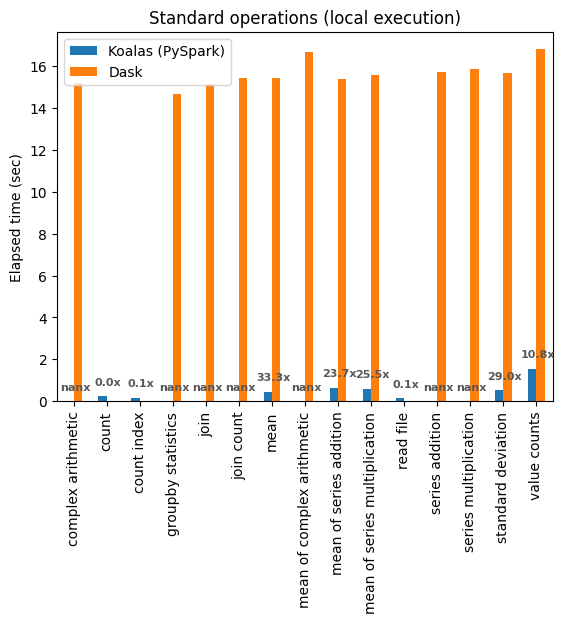

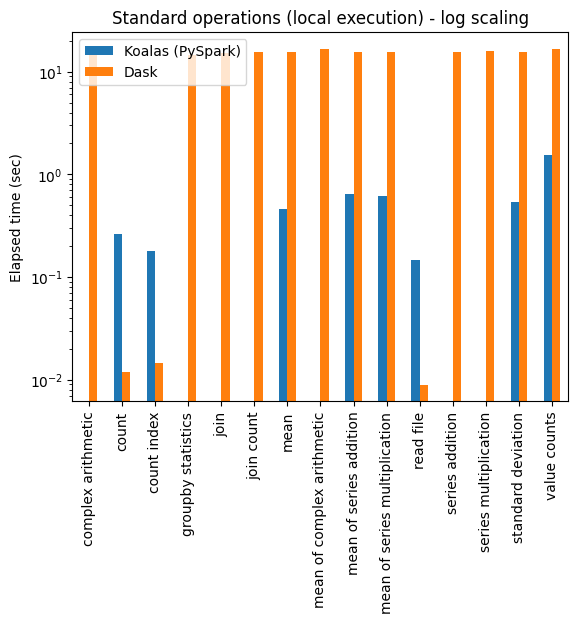

In [38]:
import matplotlib.pyplot as plt

plot_title = 'Standard operations (local execution)'
 
ax = standard_ops.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")
 
tmp_df_x_times_faster = standard_ops.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())
 
standard_ops.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [39]:
tmp_df_x_times_faster

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,NaN,15.190645,NaN,NaN
count,0.260101,0.012008,0.046167,21.660307
count index,0.177728,0.014466,0.081392,12.286272
groupby statistics,NaN,14.650766,NaN,NaN
join,NaN,15.144436,NaN,NaN
join count,NaN,15.411818,NaN,NaN
mean,0.462935,15.407151,33.281442,0.030047
mean of complex arithmetic,NaN,16.638054,NaN,NaN
mean of series addition,0.649884,15.386676,23.676035,0.042237
mean of series multiplication,0.610726,15.549762,25.461105,0.039276


# Média geométrica das razões entre os tempos de execução do Dask e do Koalas

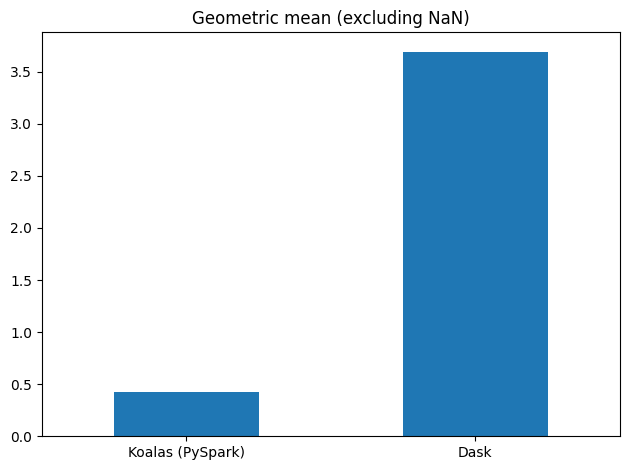

In [40]:
koalas_gmean = stats.gmean(standard_ops['Koalas (PySpark)'].dropna())
dask_gmean = stats.gmean(standard_ops['Dask'].dropna())
ax = pd.Series([koalas_gmean, dask_gmean], index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean (excluding NaN)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Tempo total de execução

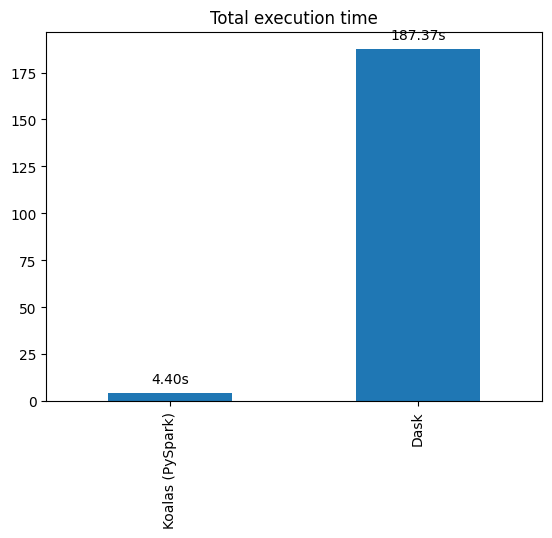

In [41]:
annotate(standard_ops.sum().plot.bar(title='Total execution time'))

# Gráficos - Dados Filtrados

Text(0, 0.5, 'Elapsed time (sec)')

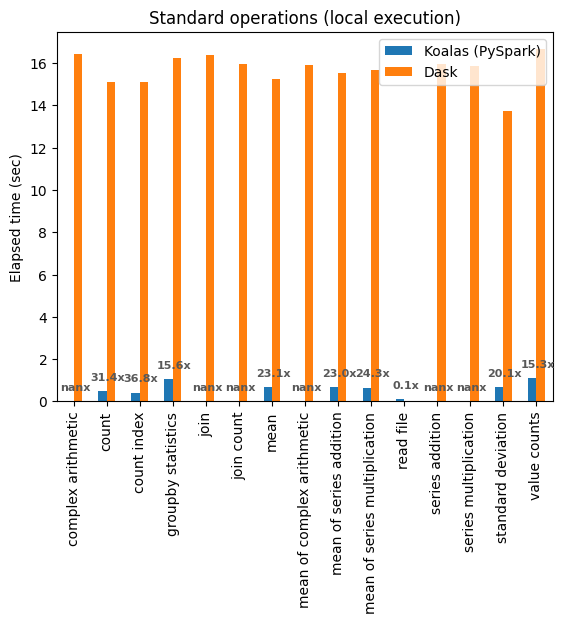

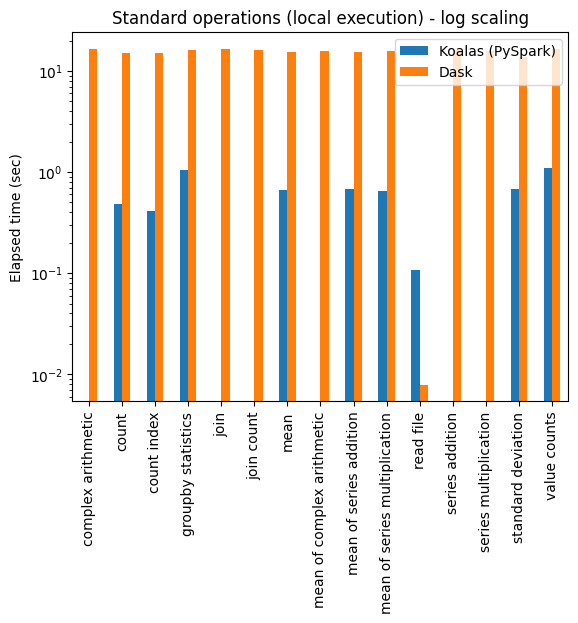

In [42]:
import matplotlib.pyplot as plt
ax = ops_with_filtering.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")
tmp_df_x_times_faster = ops_with_filtering.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())
ops_with_filtering.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [43]:
tmp_df_x_times_faster

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,NaN,16.450206,NaN,NaN
count,0.480750,15.091957,31.392521,0.031855
count index,0.411687,15.131043,36.753722,0.027208
groupby statistics,1.043396,16.225968,15.551105,0.064304
join,NaN,16.363729,NaN,NaN
join count,NaN,15.984035,NaN,NaN
mean,0.661548,15.251712,23.054584,0.043375
mean of complex arithmetic,NaN,15.893119,NaN,NaN
mean of series addition,0.677189,15.557946,22.974293,0.043527
mean of series multiplication,0.645065,15.678725,24.305658,0.041143


# Média Geométrica

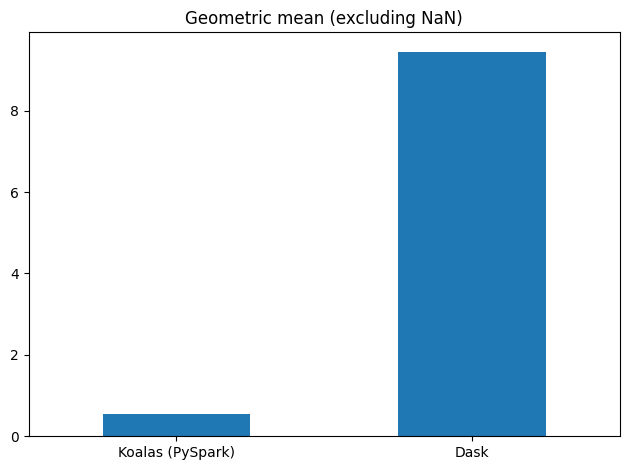

In [44]:
koalas_gmean = stats.gmean(ops_with_filtering['Koalas (PySpark)'].dropna())
dask_gmean = stats.gmean(ops_with_filtering['Dask'].dropna())
ax = pd.Series([koalas_gmean, dask_gmean], index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean (excluding NaN)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Tempo total de execução

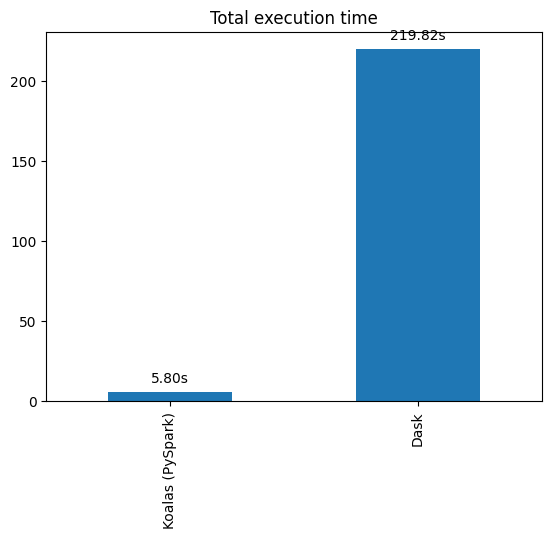

In [45]:
annotate(ops_with_filtering.sum().plot.bar(title='Total execution time'))

# Gráficos - Dados Filtrados com Caching

Text(0, 0.5, 'Elapsed time (sec)')

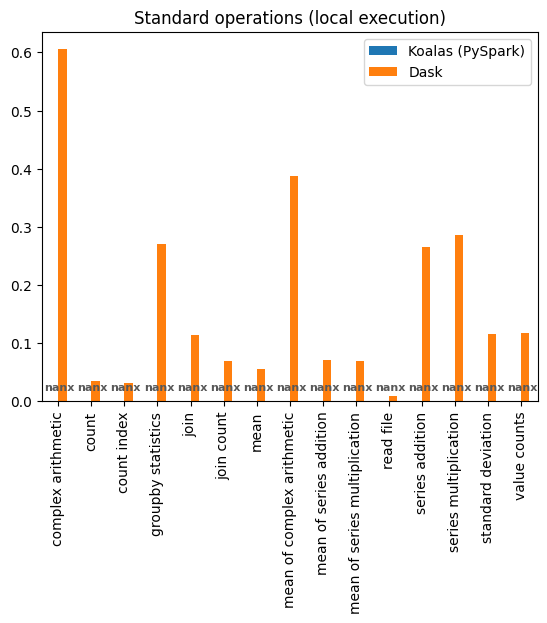

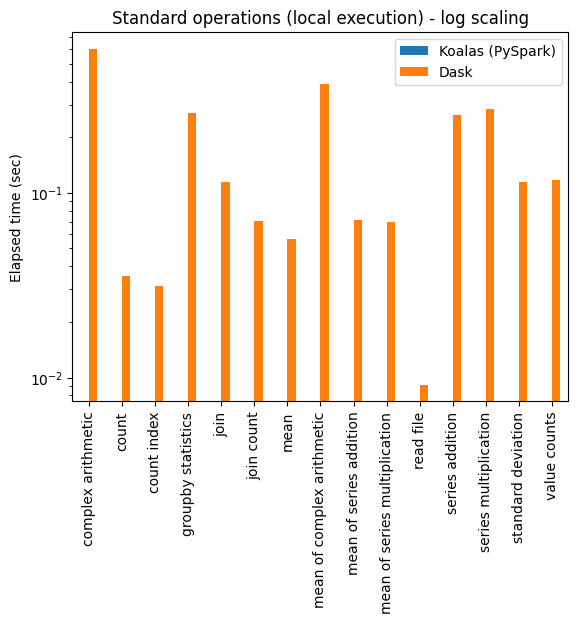

In [46]:
 ax = ops_with_filtering_caching.sort_index().plot.bar(title=plot_title)
tmp_df_x_times_faster = ops_with_filtering_caching.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())
 
ops_with_filtering_caching.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [47]:
tmp_df_x_times_faster

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
complex arithmetic,NaN,0.605202,NaN,NaN
count,NaN,0.035454,NaN,NaN
count index,NaN,0.031214,NaN,NaN
groupby statistics,NaN,0.271361,NaN,NaN
join,NaN,0.115017,NaN,NaN
join count,NaN,0.070177,NaN,NaN
mean,NaN,0.056138,NaN,NaN
mean of complex arithmetic,NaN,0.388310,NaN,NaN
mean of series addition,NaN,0.071108,NaN,NaN
mean of series multiplication,NaN,0.069629,NaN,NaN


# Média Geométrica

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


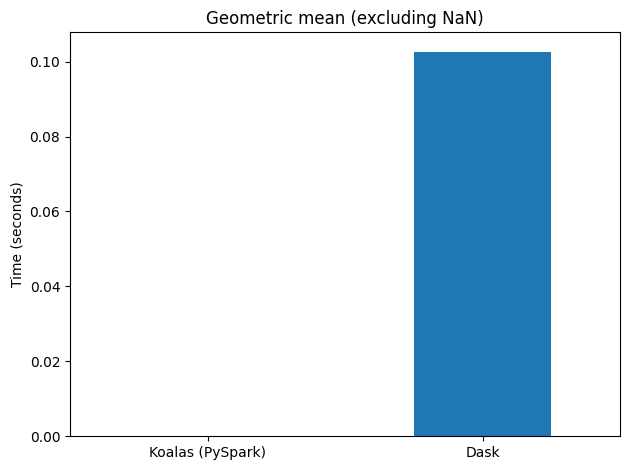

In [48]:
koalas_gmean = stats.gmean(ops_with_filtering_caching['Koalas (PySpark)'].dropna())
dask_gmean = stats.gmean(ops_with_filtering_caching['Dask'].dropna())
ax = pd.Series([koalas_gmean, dask_gmean], index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean (excluding NaN)')
ax.set_ylabel('Time (seconds)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Tempo total de execução

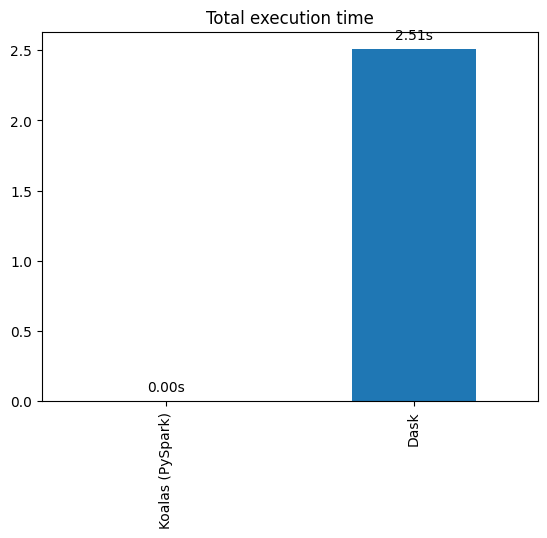

In [49]:
annotate(ops_with_filtering_caching.sum().plot.bar(title='Total execution time'))


## Observações  

Na comparação do desempenho entre as bibliotecas Koalas (PySpark) e Dask, várias operações foram realizadas sobre dados brutos, dados filtrados e dados filtrados com caching, permitindo uma análise detalhada da eficiência de cada uma.

Nas operações realizadas sem filtragem, Dask mostrou-se bastante rápido na leitura inicial dos arquivos. Contudo, para a maioria das outras operações, Koalas foi consideravelmente mais eficiente. Operações como contagem, contagem de índices, cálculos de média, desvio padrão, operações aritméticas simples e complexas, contagem de valores e estatísticas de agrupamento apresentaram tempos de execução menores com Koalas. Entretanto, algumas operações em Koalas, como adição e multiplicação de séries e operações de junção, não puderam ser concluídas devido a limitações de memória, resultando em dados faltantes (NaN).

Quando os dados foram filtrados, a vantagem de Koalas em termos de tempo de execução permaneceu clara. As operações de contagem, contagem de índices, cálculo de média e outras funções estatísticas e aritméticas foram novamente mais rápidas em Koalas. Porém, assim como no caso anterior, certas operações enfrentaram limitações de memória que impediram sua conclusão, gerando valores NaN.


De modo geral, Koalas demonstrou maior eficiência para a maioria das operações realizadas sem filtragem e com filtragem, apesar das limitações de memória que afetaram certas operações. Apesar de Koalas ser geralmente mais rápido sem caching, seu maior consumo de memória dificulta a execução completa de algumas tarefas.


# Repetição para datasets com 2 e 3 Ficheiros

In [50]:
client.restart()

# Dask

In [51]:
parquet_files2 = ['Ficheiros/taxi_csv/yellow_tripdata_2009-11.parquet', 
                 'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet']

parquet_files3 = [
    'Ficheiros/taxi_csv/yellow_tripdata_2009-10.parquet', 
    'Ficheiros/taxi_csv/yellow_tripdata_2009-11.parquet',
    'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet'
]

dask_data2 = dd.read_parquet(parquet_files2)
dask_data3 = dd.read_parquet(parquet_files3)
dask_benchmarks2 = {'duration': [], 'task': []}
dask_benchmarks_filtered2 = {'duration': [], 'task': []}
dask_benchmarks_cache2 = {'duration': [], 'task': []}

dask_benchmarks3 = {'duration': [], 'task': []}
dask_benchmarks_filtered3 = {'duration': [], 'task': []}
dask_benchmarks_cache3 = {'duration': [], 'task': []}

In [52]:
dask_data2 = dask_data2.rename(columns=str.lower)
columns_list2 = dask_data2.columns
print(columns_list2)
dask_data3 = dask_data3.rename(columns=str.lower)
columns_list3 = dask_data3.columns
print(columns_list3)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')
Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


In [53]:
dfs = [dask_data2, dask_data3]

In [54]:
def count(df=None):
    return len(df)
 
def count_index_length(df=None):
    return len(df.index)
 
def mean(df):
    return df.fare_amt.mean().compute()
 
def standard_deviation(df):
    return df.fare_amt.std().compute()
 
def mean_of_sum(df):
    return (df.fare_amt + df.tip_amt).mean().compute()
 
def sum_columns(df):
    return (df.fare_amt + df.tip_amt).compute()
 
def mean_of_product(df):
    return (df.fare_amt * df.tip_amt).mean().compute()
 
def product_columns(df):
    return (df.fare_amt * df.tip_amt).compute()
  
def value_counts(df):
    return df.fare_amt.value_counts().compute()
  
def mean_of_complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.mean().compute()
  
def complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return ret.compute()
  
def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg(
      {
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
      }
    ).compute()

for df in dfs:
    other = groupby_statistics(df)
    other.columns = pd.Index([e[0]+'' + e[1] for e in other.columns.tolist()])

def join_count(df, other):
    return len(dd.merge(df, other, left_index=True, right_index=True))
 
def join_data(df, other):
    return dd.merge(df, other, left_index=True, right_index=True).compute()

2025-06-03 20:08:15,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.55 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:08:15,607 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.52 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:08:33,877 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [55]:
for i, df in enumerate(dfs):
    benchmark(count, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'count')
    benchmark(count_index_length, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'count index length')
    benchmark(mean, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'mean')
    benchmark(standard_deviation, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'standard deviation')
    benchmark(mean_of_sum, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'mean of columns addition')
    benchmark(sum_columns, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'addition of columns')
    benchmark(mean_of_product, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'mean of columns multiplication')
    benchmark(product_columns, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'multiplication of columns')
    benchmark(value_counts, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'value counts')
    benchmark(mean_of_complicated_arithmetic_operation, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'complex arithmetic ops')
    benchmark(groupby_statistics, df=df, benchmarks=globals()[f'dask_benchmarks{i+2}'], name=f'groupby statistics')

count took: 0.01425313949584961 seconds
count index length took: 0.006908416748046875 seconds
mean took: 16.305418968200684 seconds
standard deviation took: 16.506136417388916 seconds
mean of columns addition took: 16.21994686126709 seconds
addition of columns took: 18.25602388381958 seconds
mean of columns multiplication took: 16.085193872451782 seconds
multiplication of columns took: 17.670217275619507 seconds
value counts took: 16.023526430130005 seconds
mean of complex arithmetic ops took: 16.844929933547974 seconds
complex arithmetic ops took: 19.013081550598145 seconds
groupby statistics took: 16.7766695022583 seconds
count took: 0.015949726104736328 seconds
count index length took: 0.005137920379638672 seconds


2025-06-03 20:11:43,584 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.43 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:11:43,775 - distributed.worker.memory - WARNING - Worker is at 40% memory usage. Resuming worker. Process memory: 3.19 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:12:00,269 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.28 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:12:00,516 - distributed.worker.memory - WARNING - Worker is at 41% memory usage. Resuming worker. Process memory: 3.25 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:12:17,413 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.56 GiB 

mean took: 50.26020622253418 seconds


2025-06-03 20:12:34,115 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.52 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:12:34,675 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.34 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:12:34,975 - distributed.worker.memory - WARNING - Worker is at 38% memory usage. Resuming worker. Process memory: 3.05 GiB -- Worker memory limit: 7.83 GiB


standard deviation took: 20.03347086906433 seconds


2025-06-03 20:12:54,004 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.28 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:12:54,219 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.11 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:13:11,267 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.36 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:13:11,454 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.06 GiB -- Worker memory limit: 7.83 GiB


mean of columns addition took: 35.09546875953674 seconds


2025-06-03 20:13:28,716 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.67 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:13:28,944 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.38 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:13:29,142 - distributed.worker.memory - WARNING - Worker is at 40% memory usage. Resuming worker. Process memory: 3.18 GiB -- Worker memory limit: 7.83 GiB


addition of columns took: 20.815864324569702 seconds


2025-06-03 20:13:48,677 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.56 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:13:50,304 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.27 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:13:50,538 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.06 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:14:07,569 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.33 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:14:07,770 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB 

mean of columns multiplication took: 33.937148571014404 seconds


2025-06-03 20:14:23,490 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.64 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:14:23,841 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.44 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:14:24,062 - distributed.worker.memory - WARNING - Worker is at 40% memory usage. Resuming worker. Process memory: 3.18 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:14:40,466 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.44 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:14:40,679 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB 

multiplication of columns took: 36.45214104652405 seconds


2025-06-03 20:14:59,948 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.70 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:15:00,183 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.48 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:15:00,375 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:15:16,581 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

KilledWorker: Attempted to run task ('operation-79154bca8a4cc4bdb845059e61b10a29', 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:39633. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [56]:
dask_res_temp2 = get_results(dask_benchmarks2).drop_duplicates(subset='task').set_index('task')
dask_res_temp3 = get_results(dask_benchmarks3).drop_duplicates(subset='task').set_index('task')
print(dask_res_temp2)
print(dask_res_temp3)
filename2 = 'Resultados/dask_standard2'
filename3 = 'Resultados/dask_standard3'
dask_res_temp2.to_parquet(filename2)
dask_res_temp3.to_parquet(filename3)

print(f'Guardado em {filename2}.')
print(f'Guardado em {filename3}.')

                                 duration
task                                     
count                            0.014253
count index length               0.006908
mean                            16.305419
standard deviation              16.506136
mean of columns addition        16.219947
addition of columns             18.256024
mean of columns multiplication  16.085194
multiplication of columns       17.670217
value counts                    16.023526
mean of complex arithmetic ops  16.844930
complex arithmetic ops          19.013082
groupby statistics              16.776670
                                 duration
task                                     
count                            0.015950
count index length               0.005138
mean                            50.260206
standard deviation              20.033471
mean of columns addition        35.095469
addition of columns             20.815864
mean of columns multiplication  33.937149
multiplication of columns       36

# Operações com filtro

In [57]:
def filter_data(df, expr_filter):
    return df[expr_filter]


expr_filter2 = (dask_data2.tip_amt >= 1) & (dask_data2.tip_amt <= 5)

dask_filter2 = filter_data(dask_data2, expr_filter2)
    
expr_filter3 = (dask_data3.tip_amt >= 1) & (dask_data3.tip_amt <= 5)
dask_filter3 = filter_data(dask_data3, expr_filter3)

In [58]:
dask_filtered = [dask_filter2, dask_filter3]

In [59]:
for i, df in enumerate(dask_filtered):
    benchmark(count, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered count')
    benchmark(count_index_length, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered count index length')
    benchmark(mean, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered multiplication of columns')
    benchmark(mean_of_complicated_arithmetic_operation, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'dask_benchmarks_filtered{i+2}'], name=f'filtered groupby statistics')

2025-06-03 20:16:37,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.67 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:16:37,924 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.61 GiB -- Worker memory limit: 7.83 GiB


filtered count took: 17.57585096359253 seconds
filtered count index length took: 16.610377311706543 seconds
filtered mean took: 16.875762939453125 seconds
filtered standard deviation took: 16.66505479812622 seconds
filtered mean of columns addition took: 16.604921579360962 seconds
filtered addition of columns took: 17.54185461997986 seconds
filtered mean of columns multiplication took: 16.704484462738037 seconds
filtered multiplication of columns took: 17.097145557403564 seconds
filtered mean of complex arithmetic ops took: 16.525080919265747 seconds
filtered complex arithmetic ops took: 17.598755598068237 seconds
filtered value counts took: 16.931671380996704 seconds


2025-06-03 20:19:44,119 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.27 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:19:44,126 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.07 GiB -- Worker memory limit: 7.83 GiB


filtered groupby statistics took: 16.581734657287598 seconds


2025-06-03 20:20:01,569 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.30 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:20:01,768 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.11 GiB -- Worker memory limit: 7.83 GiB


filtered count took: 17.907569646835327 seconds


2025-06-03 20:20:19,080 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.60 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:20:19,544 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.46 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:20:19,733 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB -- Worker memory limit: 7.83 GiB


filtered count index length took: 17.26164937019348 seconds


2025-06-03 20:20:36,017 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.27 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:20:36,025 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.08 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:20:36,846 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.33 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:20:37,045 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:20:53,291 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.44 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:20:53,486 - distributed.worker.memory - WARNING - Worker is at 41% memory usage. Resuming worker. Process memory: 3.25 GiB -- Worker mem

filtered mean took: 32.77129340171814 seconds


2025-06-03 20:21:08,821 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.27 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:21:08,824 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.08 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:21:09,762 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.69 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:21:10,281 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.46 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:21:10,365 - distributed.worker.memory - WARNING - Worker is at 40% memory usage. Resuming worker. Process memory: 3.18 GiB 

filtered standard deviation took: 17.892436981201172 seconds


2025-06-03 20:21:26,830 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.32 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:21:27,125 - distributed.worker.memory - WARNING - Worker is at 41% memory usage. Resuming worker. Process memory: 3.25 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:21:42,808 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.41 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:21:42,994 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.11 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:21:57,226 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.58 GiB 

filtered mean of columns addition took: 47.55124258995056 seconds


2025-06-03 20:22:14,736 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.63 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:22:15,235 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.46 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:22:15,337 - distributed.worker.memory - WARNING - Worker is at 42% memory usage. Resuming worker. Process memory: 3.30 GiB -- Worker memory limit: 7.83 GiB


filtered addition of columns took: 19.490957975387573 seconds


2025-06-03 20:22:33,989 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.47 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:22:34,176 - distributed.worker.memory - WARNING - Worker is at 40% memory usage. Resuming worker. Process memory: 3.17 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:22:50,055 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.28 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:22:50,281 - distributed.worker.memory - WARNING - Worker is at 40% memory usage. Resuming worker. Process memory: 3.18 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:23:05,906 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.50 GiB 

filtered mean of columns multiplication took: 49.40352249145508 seconds


2025-06-03 20:23:22,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.53 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:23:23,156 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.28 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:23:23,340 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.06 GiB -- Worker memory limit: 7.83 GiB


filtered multiplication of columns took: 16.97492289543152 seconds


2025-06-03 20:23:40,186 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.28 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:23:40,389 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:23:56,291 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.46 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:23:56,475 - distributed.worker.memory - WARNING - Worker is at 40% memory usage. Resuming worker. Process memory: 3.14 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:24:10,698 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.64 GiB 

filtered mean of complex arithmetic ops took: 64.88633131980896 seconds


2025-06-03 20:24:44,863 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.63 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:24:45,346 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 6.53 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:24:45,367 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.08 GiB -- Worker memory limit: 7.83 GiB


filtered complex arithmetic ops took: 18.546961545944214 seconds


2025-06-03 20:25:03,932 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.45 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:25:04,136 - distributed.worker.memory - WARNING - Worker is at 40% memory usage. Resuming worker. Process memory: 3.17 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:25:20,464 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.47 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:25:20,639 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB -- Worker memory limit: 7.83 GiB


filtered value counts took: 34.550583362579346 seconds


2025-06-03 20:25:38,116 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.76 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:25:38,715 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.29 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:25:38,921 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:25:54,258 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.40 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:25:54,435 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB 

filtered groupby statistics took: 65.05078053474426 seconds


In [60]:
dask_res_filter2 = get_results(dask_benchmarks_filtered2).drop_duplicates(subset='task').set_index('task')
dask_res_filter3 = get_results(dask_benchmarks_filtered3).drop_duplicates(subset='task').set_index('task')
print(dask_res_filter2)
print(dask_res_filter3)
filename_filter2 = 'Resultados/dask_filtered2'
filename_filter3 = 'Resultados/dask_filtered3'
dask_res_filter2.to_parquet(filename_filter2)
dask_res_filter3.to_parquet(filename_filter3)
print(f'Guardado em {filename_filter2}.')
print(f'Guardado em {filename_filter3}.')

                                          duration
task                                              
filtered count                           17.575851
filtered count index length              16.610377
filtered mean                            16.875763
filtered standard deviation              16.665055
filtered mean of columns addition        16.604922
filtered addition of columns             17.541855
filtered mean of columns multiplication  16.704484
filtered multiplication of columns       17.097146
filtered mean of complex arithmetic ops  16.525081
filtered complex arithmetic ops          17.598756
filtered value counts                    16.931671
filtered groupby statistics              16.581735
                                          duration
task                                              
filtered count                           17.907570
filtered count index length              17.261649
filtered mean                            32.771293
filtered standard deviation    

# Operações com filtro e caching

O código cache aos DataFrames filtrados para garantir que os resultados dos cálculos sejam armazenados e não precisem ser recalculados. Para isso, cada DataFrame é persistido na memória para acesso rápido. Depois de armazenar cada DataFrame, o código aguarda a conclusão de todos os cálculos relacionados antes de seguir adiante. Durante esse processo, são exibidas mensagens que informam quando a espera pelos cálculos começa e quando termina.

In [61]:
from distributed import wait

for i, df in enumerate(dask_filtered):
    dask_filtered[i] = client.persist(df)
    print(f'Waiting until all futures for set {i+2} are finished')
    wait(dask_filtered[i])
    print(f'All futures for set {i+2} are finished')

Waiting until all futures for set 2 are finished


2025-06-03 20:26:42,802 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.78 GiB -- Worker memory limit: 7.83 GiB


All futures for set 2 are finished
Waiting until all futures for set 3 are finished


2025-06-03 20:26:58,831 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.29 GiB -- Worker memory limit: 7.83 GiB
2025-06-03 20:26:59,221 - distributed.worker.memory - WARNING - Worker is at 39% memory usage. Resuming worker. Process memory: 3.12 GiB -- Worker memory limit: 7.83 GiB


All futures for set 3 are finished


## Execução de Benchmarks em DataFrames em Cache

O código percorre uma lista de DataFrames que foram filtrados e armazenados em cache, realizando testes de desempenho para diversas operações como contagem, média, desvio padrão e operações aritméticas complexas.  

Os resultados de cada teste são guardados em estruturas específicas, nomeadas de acordo com a operação realizada e a posição do DataFrame na lista. Essa organização permite comparar o desempenho para diferentes conjuntos de dados, identificados pelo número de arquivos utilizados.


In [62]:
for i, df in enumerate(dask_filtered):
    benchmark(count, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache count')
    benchmark(count_index_length, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache count index length')
    benchmark(mean, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache multiplication of columns')
    benchmark(mean_of_complicated_arithmetic_operation, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'dask_benchmarks_cache{i+2}'], name=f'cache groupby statistics')

cache count took: 1.6074309349060059 seconds
cache count index length took: 0.028011798858642578 seconds
cache mean took: 0.05036497116088867 seconds
cache standard deviation took: 0.10948705673217773 seconds
cache mean of columns addition took: 0.06749200820922852 seconds
cache addition of columns took: 0.5556361675262451 seconds
cache mean of columns multiplication took: 0.07061123847961426 seconds
cache multiplication of columns took: 0.5681517124176025 seconds
cache mean of complex arithmetic ops took: 0.39284491539001465 seconds
cache complex arithmetic ops took: 0.8669946193695068 seconds
cache value counts took: 0.19185400009155273 seconds
cache groupby statistics took: 0.2669844627380371 seconds
cache count took: 0.032219648361206055 seconds
cache count index length took: 0.03980135917663574 seconds
cache mean took: 0.05337047576904297 seconds
cache standard deviation took: 0.11249113082885742 seconds
cache mean of columns addition took: 0.07546401023864746 seconds
cache additi

In [74]:
dask_res_cache2 = get_results(dask_benchmarks_cache2).drop_duplicates(subset='task').set_index('task')
dask_res_cache3 = get_results(dask_benchmarks_cache3).drop_duplicates(subset='task').set_index('task')
print(dask_res_cache2)
print(dask_res_cache3)
filename_cache2 = 'Resultados/dask_cache2'
filename_cache3 = 'Resultados/dask_cache3'
dask_res_cache2.to_parquet(filename_cache2)
dask_res_cache3.to_parquet(filename_cache3)

print(f'Guardado em {filename_cache2}.')
print(f'Guardado em {filename_cache3}.')

                                      duration
task                                          
cache count                           1.607431
cache count index length              0.028012
cache mean                            0.050365
cache standard deviation              0.109487
cache mean of columns addition        0.067492
cache addition of columns             0.555636
cache mean of columns multiplication  0.070611
cache multiplication of columns       0.568152
cache mean of complex arithmetic ops  0.392845
cache complex arithmetic ops          0.866995
cache value counts                    0.191854
cache groupby statistics              0.266984
                                      duration
task                                          
cache count                           0.032220
cache count index length              0.039801
cache mean                            0.053370
cache standard deviation              0.112491
cache mean of columns addition        0.075464
cache additio

In [78]:
client.restart()

## Koalas

Selecionaram-se as maiores amostras do dataset original para análise.

- **Leitura de dois arquivos:** Dois arquivos Parquet
- **Leitura de três arquivos:** Três arquivos Parquet



In [5]:
koalas_data2 = ks.read_parquet([
    'Ficheiros/taxi_csv/yellow_tripdata_2009-11.parquet', 
    'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet'
])

koalas_data3 = ks.read_parquet([
    'Ficheiros/taxi_csv/yellow_tripdata_2009-10.parquet', 
    'Ficheiros/taxi_csv/yellow_tripdata_2009-11.parquet',
    'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet'
])

koalas_benchmarks2 = {'duration': [], 'task': []}
koalas_benchmarks_filtered2 = {'duration': [], 'task': []}
koalas_benchmarks_cache2 = {'duration': [], 'task': []}
koalas_benchmarks3 = {'duration': [], 'task': []}
koalas_benchmarks_filtered3 = {'duration': [], 'task': []}
koalas_benchmarks_cache3 = {'duration': [], 'task': []}

/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_parquet`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/03 20:37:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
current_columns2 = koalas_data2.columns
rename_dict2 = {col: col.lower() for col in current_columns2}
koalas_data2 = koalas_data2.rename(columns=rename_dict2)
columns_list2 = koalas_data2.columns
print(columns_list2)
current_columns3 = koalas_data3.columns
rename_dict3 = {col: col.lower() for col in current_columns3}
koalas_data3 = koalas_data3.rename(columns=rename_dict3)
columns_list3 = koalas_data3.columns
print(columns_list3)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')
Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


In [7]:
dfs = [koalas_data2, koalas_data3]

## Definição das Funções de Benchmark

Foram criadas várias funções para executar operações estatísticas, aritméticas e manipulações nos DataFrames.

- **Agrupamento e conversão:** Aplica-se uma função de agrupamento (`groupby_statistics`) aos DataFrames e converte os resultados para DataFrames do pandas, com colunas renomeadas para indicar as estatísticas calculadas.

- **Funções de contagem:** incluem contagem de linhas (`count`) e contagem do tamanho do índice (`count_index_length`).

- **Funções estatísticas:** calculam média, desvio padrão, soma e produto de colunas específicas (como `fare_amt` e `tip_amt`), além da contagem de valores.

- **Operações aritméticas complexas:** envolvem cálculos baseados em coordenadas geográficas e suas médias.

- **Funções de junção:** definem operações para contar linhas resultantes e realizar junções entre DataFrames, mas foram comentadas devido a erros por falta de memória durante os benchmarks.


In [8]:
import pyspark.sql.functions as F
def count(df=None):
    return len(df)
 
def count_index_length(df=None):
    return len(df.index)
 
def mean(df):
    return df.fare_amt.mean()
 
def standard_deviation(df):
    return df.fare_amt.std()
 
def mean_of_sum(df):
    return (df.fare_amt + df.tip_amt).mean()
 
def sum_columns(df):
    x = df.fare_amt + df.tip_amt
    x.to_pandas()
    return x
 
def mean_of_product(df):
    return (df.fare_amt * df.tip_amt).mean()
 
def product_columns(df):
    x = df.fare_amt * df.tip_amt
    x.to_pandas()
    return x
 
def value_counts(df):
    val_counts = df.fare_amt.value_counts()
    val_counts.to_pandas()
    return val_counts
  
def complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180) * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = np.multiply(np.arctan2(np.sqrt(temp), np.sqrt(1-temp)),2)
    ret.to_pandas()
    return ret
  
def mean_of_complicated_arithmetic_operation(df):
    theta_1 = df.start_lon
    phi_1 = df.start_lat
    theta_2 = df.end_lon
    phi_2 = df.end_lat
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180) * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = np.multiply(np.arctan2(np.sqrt(temp), np.sqrt(1-temp)),2) 
    return ret.mean()
  
def groupby_statistics(df):
    gb = df.groupby(by='passenger_count').agg(
      {
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
      }
    )
    gb.to_pandas()
    return gb
  

for df in dfs:
    other = ks.DataFrame(groupby_statistics(df).to_pandas())
    other.columns = pd.Index([e[0]+'_' + e[1] for e in other.columns.tolist()])

def join_count(df, other):
    return len(df.merge(other.spark.hint("broadcast"), left_index=True, right_index=True))
 
def join_data(df, other):
    ret = df.merge(other.spark.hint("broadcast"), left_index=True, right_index=True)
    ret.to_pandas()
    return ret

/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data 

## Medição de Desempenho em DataFrame Koalas

Realiza benchmarks em um DataFrame Koalas, registrando o tempo gasto em várias operações para análise de desempenho. Os resultados são armazenados no dicionário `koalas_benchmarks2`.

As operações avaliadas incluem:

- Contagem total de linhas.
- Contagem do comprimento do índice.
- Cálculo da média da coluna `fare_amt`.
- Cálculo do desvio padrão da coluna `fare_amt`.
- Cálculo da média da soma das colunas `fare_amt` e `tip_amt`.
- Cálculo da média do produto das colunas `fare_amt` e `tip_amt`.
- Contagem da frequência dos valores na coluna `fare_amt`.
- Agrupamento por `passenger_count` com cálculo da média e desvio padrão de `fare_amt` e `tip_amt`.


In [11]:
benchmark(count, df=dfs[0], benchmarks=globals()[f'koalas_benchmarks2'], name=f'count')
benchmark(count_index_length, df=dfs[0], benchmarks=globals()[f'koalas_benchmarks2'], name=f'count index length')
benchmark(mean, df=dfs[0], benchmarks=globals()[f'koalas_benchmarks2'], name=f'mean')
benchmark(standard_deviation, df=dfs[0], benchmarks=globals()[f'koalas_benchmarks2'], name=f'standard deviation')
benchmark(mean_of_sum, df=dfs[0], benchmarks=globals()[f'koalas_benchmarks2'], name=f'mean of columns addition')
benchmark(mean_of_product, df=dfs[0], benchmarks=globals()[f'koalas_benchmarks2'], name=f'mean of columns multiplication')
benchmark(value_counts, df=dfs[0], benchmarks=globals()[f'koalas_benchmarks2'], name=f'value counts')
benchmark(groupby_statistics, df=dfs[0], benchmarks=globals()[f'koalas_benchmarks2'], name=f'groupby statistics')

count took: 0.18846702575683594 seconds
count index length took: 0.11054468154907227 seconds
mean took: 0.459911584854126 seconds
standard deviation took: 0.4907398223876953 seconds
mean of columns addition took: 0.6142010688781738 seconds
mean of columns multiplication took: 0.6000981330871582 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


value counts took: 1.5996711254119873 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


groupby statistics took: 1.4540739059448242 seconds


1.4540739059448242

In [12]:
benchmark(count, df=dfs[1], benchmarks=globals()[f'koalas_benchmarks3'], name=f'count')
benchmark(count_index_length, df=dfs[1], benchmarks=globals()[f'koalas_benchmarks3'], name=f'count index length')
benchmark(mean, df=dfs[1], benchmarks=globals()[f'koalas_benchmarks3'], name=f'mean')
benchmark(standard_deviation, df=dfs[1], benchmarks=globals()[f'koalas_benchmarks3'], name=f'standard deviation')
benchmark(mean_of_sum, df=dfs[1], benchmarks=globals()[f'koalas_benchmarks3'], name=f'mean of columns addition')
benchmark(mean_of_product, df=dfs[1], benchmarks=globals()[f'koalas_benchmarks3'], name=f'mean of columns multiplication')
benchmark(value_counts, df=dfs[1], benchmarks=globals()[f'koalas_benchmarks3'], name=f'value counts')
benchmark(groupby_statistics, df=dfs[1], benchmarks=globals()[f'koalas_benchmarks3'], name=f'groupby statistics')


count took: 0.10048770904541016 seconds
count index length took: 0.09254717826843262 seconds
mean took: 0.3728060722351074 seconds
standard deviation took: 0.45063257217407227 seconds


mean of columns addition took: 0.6976504325866699 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


mean of columns multiplication took: 0.7284245491027832 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


value counts took: 1.3030238151550293 seconds


groupby statistics took: 1.6057734489440918 seconds


1.6057734489440918

In [13]:
koalas_res_temp2 = get_results(koalas_benchmarks2).drop_duplicates(subset='task').set_index('task')
koalas_res_temp3 = get_results(koalas_benchmarks3).drop_duplicates(subset='task').set_index('task')
print(koalas_res_temp2)
print(koalas_res_temp3)
filename2 = 'Resultados/koalas_standard2'
filename3 = 'Resultados/koalas_standard3'
koalas_res_temp2.to_parquet(filename2)
koalas_res_temp3.to_parquet(filename3)

print(f'Guardado em {filename2}.')
print(f'Guardado em {filename3}.')

                                duration
task                                    
count                           0.188467
count index length              0.110545
mean                            0.459912
standard deviation              0.490740
mean of columns addition        0.614201
mean of columns multiplication  0.600098
value counts                    1.599671
groupby statistics              1.454074
                                duration
task                                    
count                           0.100488
count index length              0.092547
mean                            0.372806
standard deviation              0.450633
mean of columns addition        0.697650
mean of columns multiplication  0.728425
value counts                    1.303024
groupby statistics              1.605773
Guardado em Resultados/koalas_standard2.
Guardado em Resultados/koalas_standard3.


# Operações com filtro

In [14]:
def filter_data(df, expr_filter):
    return df[expr_filter]


expr_filter2 = (koalas_data2.tip_amt >= 1) & (koalas_data2.tip_amt <= 5)

dask_filter2 = filter_data(koalas_data2, expr_filter2)
    
expr_filter3 = (koalas_data3.tip_amt >= 1) & (koalas_data3.tip_amt <= 5)
dask_filter3 = filter_data(koalas_data3, expr_filter3)

In [15]:
koalas_filtered=[koalas_data2,koalas_data3]

In [16]:
benchmark(count, df=koalas_filtered[0], benchmarks=globals()[f'koalas_benchmarks_filtered2'], name=f'count')
benchmark(count_index_length, df=koalas_filtered[0], benchmarks=globals()[f'koalas_benchmarks_filtered2'], name=f'count index length')
benchmark(mean, df=koalas_filtered[0], benchmarks=globals()[f'koalas_benchmarks_filtered2'], name=f'mean')
benchmark(standard_deviation, df=koalas_filtered[0], benchmarks=globals()[f'koalas_benchmarks_filtered2'], name=f'standard deviation')
benchmark(mean_of_sum, df=koalas_filtered[0], benchmarks=globals()[f'koalas_benchmarks_filtered2'], name=f'mean of columns addition')
benchmark(mean_of_product, df=koalas_filtered[0], benchmarks=globals()[f'koalas_benchmarks_filtered2'], name=f'mean of columns multiplication')
benchmark(value_counts, df=koalas_filtered[0], benchmarks=globals()[f'koalas_benchmarks_filtered2'], name=f'value counts')
benchmark(groupby_statistics, df=koalas_filtered[0], benchmarks=globals()[f'koalas_benchmarks_filtered2'], name=f'groupby statistics')

count took: 0.07885527610778809 seconds
count index length took: 0.07007956504821777 seconds
mean took: 0.2742767333984375 seconds
standard deviation took: 0.3832120895385742 seconds
mean of columns addition took: 0.4462597370147705 seconds
mean of columns multiplication took: 0.517669677734375 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


value counts took: 1.1723697185516357 seconds


groupby statistics took: 1.5013060569763184 seconds


1.5013060569763184

In [17]:
benchmark(count, df=koalas_filtered[1], benchmarks=globals()[f'koalas_benchmarks_filtered3'], name=f'count')
benchmark(count_index_length, df=koalas_filtered[1], benchmarks=globals()[f'koalas_benchmarks_filtered3'], name=f'count index length')
benchmark(mean, df=koalas_filtered[1], benchmarks=globals()[f'koalas_benchmarks_filtered3'], name=f'mean')
benchmark(standard_deviation, df=koalas_filtered[1], benchmarks=globals()[f'koalas_benchmarks_filtered3'], name=f'standard deviation')
benchmark(mean_of_sum, df=koalas_filtered[1], benchmarks=globals()[f'koalas_benchmarks_filtered3'], name=f'mean of columns addition')
benchmark(mean_of_product, df=koalas_filtered[1], benchmarks=globals()[f'koalas_benchmarks_filtered3'], name=f'mean of columns multiplication')
benchmark(value_counts, df=koalas_filtered[1], benchmarks=globals()[f'koalas_benchmarks_filtered3'], name=f'value counts')
benchmark(groupby_statistics, df=koalas_filtered[1], benchmarks=globals()[f'koalas_benchmarks_filtered3'], name=f'groupby statistics')


count took: 0.05930352210998535 seconds
count index length took: 0.05974912643432617 seconds
mean took: 0.3346681594848633 seconds
standard deviation took: 0.41202878952026367 seconds
mean of columns addition took: 0.5367434024810791 seconds
mean of columns multiplication took: 0.5143721103668213 seconds


/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/conda/lib/python3.10/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


value counts took: 1.2664470672607422 seconds


groupby statistics took: 1.546515941619873 seconds


1.546515941619873

In [18]:
koalas_res_filtered2 = get_results(koalas_benchmarks_filtered2).drop_duplicates(subset='task').set_index('task')
koalas_res_filtered3 = get_results(koalas_benchmarks_filtered3).drop_duplicates(subset='task').set_index('task')
print(koalas_res_filtered2)
print(koalas_res_filtered3)
filename_filtered2 = 'Resultados/koalas_filtered2'
filename_filtered3 = 'Resultados/koalas_filtered3'
koalas_res_filtered2.to_parquet(filename_filtered2)
koalas_res_filtered3.to_parquet(filename_filtered3)

print(f'Guardado em {filename_filtered2}.')
print(f'Guardado em {filename_filtered3}.')

                                duration
task                                    
count                           0.078855
count index length              0.070080
mean                            0.274277
standard deviation              0.383212
mean of columns addition        0.446260
mean of columns multiplication  0.517670
value counts                    1.172370
groupby statistics              1.501306
                                duration
task                                    
count                           0.059304
count index length              0.059749
mean                            0.334668
standard deviation              0.412029
mean of columns addition        0.536743
mean of columns multiplication  0.514372
value counts                    1.266447
groupby statistics              1.546516
Guardado em Resultados/koalas_filtered2.
Guardado em Resultados/koalas_filtered3.
